In [5]:
import numpy as np
import pandas as pd
import time, re

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Conv1D
from keras.layers import Dropout, Activation, MaxPooling1D, SpatialDropout1D
from keras.layers.embeddings import Embedding

from keras.callbacks import EarlyStopping
from keras import regularizers, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


 # **Preprocessing**

**Source Set**

In [6]:
cols = ['sentiment','text']
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/training_big.csv',encoding='latin-1',header=None, \
                 names=cols, usecols=[0,5])

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

X = df['text'].fillna('').tolist()
X = [str(i) for i in X]
X = [re.sub('@[^\s]+','',i) for i in X]
y = df['sentiment'].fillna('').tolist()
print('X sample:',X[0])
print('y sample:',y[0])

X sample:  http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
y sample: 0


In [20]:
print('Loading data...')
# Balance classes 
class_weights = compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Clean text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to integer sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

y_train = to_categorical(y_train, 2, dtype='int64')
y_test = to_categorical(y_test, 2, dtype='int64')

vocab_size = len(tokenizer.word_index) + 1  
print('Found %s unique tokens.' % vocab_size)
maxlen = 100

# Sequences that are shorter than the max length are padded with value
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Loading data...
Found 289051 unique tokens.
X_train shape: (1072000, 100)
X_test shape: (528000, 100)


**Target Set**

In [0]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"it\Õs", "it is", phrase)
    phrase = re.sub(r"don\Õt", "do not", phrase)
    phrase = re.sub(r"isn\Õt", "is not", phrase)
    phrase = re.sub(r"I\Õm", "I am", phrase)
    phrase = re.sub(r"can\Õt", "can not", phrase)
    phrase = re.sub(r"\Õve", "have", phrase)
    return phrase

cols_target = ['target','text','label']
target_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/bin_manifesto.csv', encoding='latin-1', header=None, \
                     names=cols_target, usecols=[0,1,2])
target_df = target_df[['target','text','label']]
X_target = target_df['text'].fillna('').tolist()
X_target = [decontracted(str(i)) for i in X_target]
targ_targ = target_df['target'].fillna('').tolist()
y_target = target_df['label'].fillna('').tolist()

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_target)

X_target = tokenizer.texts_to_sequences(X_target)
X_target = pad_sequences(X_target, padding='post', maxlen=maxlen)

print('In-sample shape:', X_train.shape)
print('Out-of-sample shape:', X_target.shape)

In-sample shape: (1072000, 100)
Out-of-sample shape: (850, 100)


# **Embeddings**

**GloVe**

In [0]:
glove_path = '/content/gdrive/My Drive/Colab Notebooks/Data/glove.twitter.27B/glove.twitter.27B.200d.txt'

embeddings_index = dict()
with open(glove_path,
          encoding="utf8") as glove:
  for line in glove:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  glove.close()

In [0]:
embedding_matrix = np.zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# **TextCNN**

**Pipeline**

In [0]:
%%time

#Parameters
maxlen = maxlen
num_filters = 32
weight_decay = 1e-4
embedding_dim = 200
batch_size = 256
epochs = 20

print('Build CNN model...')
model = Sequential()
# First layer
model.add(Embedding(vocab_size, embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D())
# Second layer
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D())
# Third layer
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
# CLASSIFICATION
# Fully connected layer
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
# Output layer w/ sigmoid
model.add(Dense(2, activation='sigmoid'))

# Compile the model
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn_history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              class_weight=class_weights)

model.save('my_cnn.h5')

**Retraining**

In [0]:
cnn_model_A = load_model('my_cnn.h5')

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_target, y_target, test_size=0.33, random_state=33)

y_train_B = to_categorical(y_train_B, 2, dtype='int64')
y_test_B = to_categorical(y_test_B, 2, dtype='int64')

cnn_model_B_on_A = Sequential(cnn_model_A.layers[:-1])
cnn_model_B_on_A.add(Dense(2, activation="sigmoid"))

for layer in cnn_model_B_on_A.layers[:-1]:
    trainable = True

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cnn_model_B_on_A.compile(loss="binary_crossentropy", optimizer=adam,
                     metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

cnn_B_history = cnn_model_B_on_A.fit(X_train_B, y_train_B, epochs=10,
                           validation_data=(X_test_B, y_test_B),
                           callbacks=callbacks)

loss, acc = model.evaluate(X_train_B, y_train_B, verbose=True)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(X_test_B, y_test_B, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))

cnn_model_B_on_A.save('my_cnn_B.h5')

**Evaluation**

In [0]:
def argmax_keepdims(x, axis):
    output_shape = list(x.shape)
    output_shape[axis] = 1
    return np.argmax(x, axis=axis).reshape(output_shape)

y_test_fit = argmax_keepdims(y_test_B , axis=1)

cnn_model_B = load_model('my_cnn_B.h5')
y_pred = cnn_model_B.predict_classes(X_test_B)

target_names = ['negative', 'non-negative']
print('----------------------EVALUATION----------------------\n')
print(classification_report(y_test_fit, y_pred, target_names=target_names))

# **BiLSTM**

**Pipeline**

In [0]:
%%time

#Parameters
maxlen = maxlen
lstm_output_size = 70
weight_decay = 1e-4
embedding_dim = 200
batch_size = 256
kernel_size = 4
epochs = 20

print('Build LSTM model...')
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(lstm_output_size, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lstm_history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              class_weight=class_weights)

model.save('my_lstm.h5')

**Retraining**

In [0]:
lstm_model_A = load_model('my_lstm.h5')

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_oos, y_oos, test_size=0.33, random_state=33)

y_train_B = to_categorical(y_train_B, 2, dtype='int64')
y_test_B = to_categorical(y_test_B, 2, dtype='int64')

lstm_model_B_on_A = Sequential(lstm_model_A.layers[:-1])
lstm_model_B_on_A.add(Dense(2, activation="sigmoid"))

for layer in lstm_model_B_on_A.layers[:-1]:
    trainable = True

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
lstm_model_B_on_A.compile(loss="binary_crossentropy", optimizer=adam,
                     metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

lstm_B_history = lstm_model_B_on_A.fit(X_train_B, y_train_B, epochs=10,
                           validation_data=(X_test_B, y_test_B),
                           callbacks=callbacks)

loss, acc = model.evaluate(X_train_B, y_train_B, verbose=True)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(X_test_B, y_test_B, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))

lstm_model_B_on_A.save('my_lstm_B.h5')

**Evaluation**

In [0]:
def argmax_keepdims(x, axis):
    output_shape = list(x.shape)
    output_shape[axis] = 1
    return np.argmax(x, axis=axis).reshape(output_shape)

y_test_fit = argmax_keepdims(y_test_B , axis=1)

lstm_model_B = load_model('my_lstm_B.h5')
y_pred = lstm_model_B.predict_classes(X_test_B)

target_names = ['negative', 'non-negative']
print('----------------------EVALUATION----------------------\n')
print(classification_report(y_test_fit, y_pred, target_names=target_names))

# **BERT**

In [0]:
!pip install ktrain

In [0]:
import ktrain
from ktrain import text

from tensorflow.python.keras.layers import Layer, InputSpec

In [0]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_array(X, y, 
                                                                      max_features=vocab_size,
                                                                      maxlen=maxlen, 
                                                                      preprocess_mode='bert')

In [0]:
model = text.text_classifier('bert', (X_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(X_train_B, y_train_B), val_data=(X_test_B, y_test_B), batch_size=12)

# find a good learning rate
learner.lr_find()
learner.lr_plot()

# train using triangular learning rate policy
learner.autofit(0.0007, 1)

**Predictions**

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc)
bert_pred_class = predictor.predict(X_oos)
bert_pred_prob = predictor.predict_proba(X_oos)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_oos)
X_oos = tokenizer.texts_to_sequences(X_oos)

# Show the inputs and predicted outputs
for i in range(5):
  print("X=%s, Predicted=%s" % (tokenizer.sequences_to_texts(X_oos)[i], bert_pred_class[i]))

**Evaluation**

In [0]:
def argmax_keepdims(x, axis):
    output_shape = list(x.shape)
    output_shape[axis] = 1
    return np.argmax(x, axis=axis).reshape(output_shape)

bert_pred_fit = argmax_keepdims(bert_pred_prob, axis=1)

target_names = ['negative', 'non-negative']
print('----------------------EVALUATION----------------------\n')
print(classification_report(y_test_B, bert_pred_fit, target_names=target_names))

# **Manifesto Topic Modeling**

In [0]:
!pip install mglearn

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import mglearn

vect = CountVectorizer(max_features=10000, max_df=.15)
X_target = vect.fit_transform(X_target)

lda = LatentDirichletAllocation(n_components=10, learning_method='batch',
                                max_iter=25, random_state=8)
document_topics = lda.fit_transform(X_target)

print(lda.components_.shape)

# Sort the ascending features for each topic (row in component_)
# Invert row to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:,::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out topics
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=15)

(10, 9606)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
fucking       love          he            fucking       want          
now           hate          man           then          how           
know          european      been          its           some          
too           power         those         change        could         
where         men           think         think         were          
need          us            his           us            any           
think         replacement   white         must          must          
own           new           how           thatõs        never         
see           human         never         how           own           
love          political     him           need          fucking       
some          these         now           should        fuck          
toxic         make          human         make          live      

In [0]:
# Sort by weight of topic
topic = np.argsort(document_topics[:,10])[::-1]

# Print the five documents where topic is most relevant
for i in topic[:1]:
  print(b".".joing(X_combo[i].split(b".")[:1]) +b'.\n')

In [0]:
# Topic weights learned
fig, ax = plt.subplots(1,2,figsize=10,10))
topic_names = ["{:>2}".format(i)+ " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]
# 2 column bar chart:
for col in [0,1]:
  start = col * 50
  end = (col+1) * 50
  ax[col].barh(np.arrange(50), np.sum(document_topics, axis=0))[start:end])
  ax[col].set_yticks(np.arrange(50))
  ax[col].set_ytickslabels(topic_names[start:end], ha='left', va='top')
  ax[col].invert_yaxis()
  yax = ax[col].get_yaxis
  yax.set_tick_params(pad=130)
plt.tight_layout() 

# **Manifesto Word Clouds**

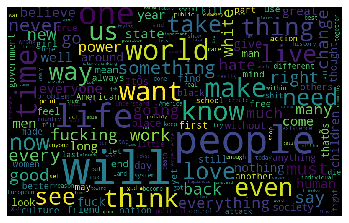

In [0]:
from wordcloud import WordCloud
from collections import Counter

def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"it\Õs", "it is", phrase)
    phrase = re.sub(r"don\Õt", "do not", phrase)
    phrase = re.sub(r"isn\Õt", "is not", phrase)
    phrase = re.sub(r"I\Õm", "I am", phrase)
    phrase = re.sub(r"can\Õt", "can not", phrase)
    phrase = re.sub(r"\Õve", "have", phrase)
    return phrase

cols_oos = ['target','text']
oos_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/manifesto.csv', encoding='latin-1', header=None, \
                     names=cols_oos, usecols=[0,1])
oos_df = oos_df[['target','text']]
X_oos = oos_df['text'].fillna('').tolist()
X_oos = [decontracted(str(i)) for i in X_oos]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_oos)

# Wordcloud
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(" ".join([token for token in X_oos]))
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()